1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



In [2]:
import numpy as np
from scipy import fftpack 
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from scipy import optimize
import calendar
from scipy import stats
import datetime as dt
import pandas as pd
from scipy.interpolate import UnivariateSpline

maximum wind speed occurring every 50 years: 32.97989825386221 m/s


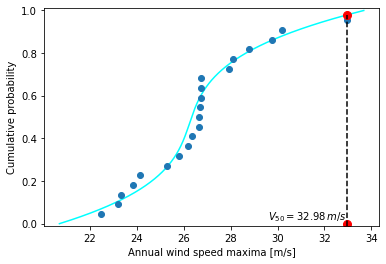

In [3]:
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
cprob = (np.arange(years_nb, dtype=np.float32) + 1)/(years_nb + 1)
sorted_max_speeds = np.sort(max_speeds)
quantile_func = UnivariateSpline(cprob, sorted_max_speeds)
nprob = np.linspace(0, 1, 500) 
fitted_max_speeds = quantile_func(nprob)
fifty_prob = 1. - 0.02
fifty_wind = quantile_func(fifty_prob) #x*=(F^(-1))(p) 
print("maximum wind speed occurring every 50 years:",fifty_wind,"m/s")
plt.figure()
plt.xlabel('Annual wind speed maxima [m/s]')
plt.ylabel('Cumulative probability')
plt.ylim([-0.01,1.01])
plt.plot(fitted_max_speeds, nprob, color="cyan")
plt.plot(sorted_max_speeds, cprob, 'o')
plt.plot([fifty_wind], [fifty_prob], 'o', ms=8., mfc='r', mec='r')
plt.text(29.6, 0.02, '$V_{50} = %.2f \, m/s$' % fifty_wind)
plt.plot([fifty_wind], 0, 'o', ms=8., mfc='r', mec='r')
plt.plot([fifty_wind, fifty_wind], [plt.axis()[2], fifty_prob], 'k--')
plt.show()

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

par fit (average, amplitude, time offset)
min: (guess [-40, -25, 0])
 [-39.66666666 -25.58169525  -0.15603654] 
 [[ 1.63081377e+00 -2.34218663e-08 -1.86659456e-08]
 [-2.34218663e-08  3.26162754e+00  3.39773649e-08]
 [-1.86659456e-08  3.39773649e-08  1.81794124e-02]]
max: (guess [25, -10, 0])
 [ 26.75       -10.93254951   0.27651998] 
 [[1.58575615e-01 1.44093331e-09 1.73859550e-09]
 [1.44093331e-09 3.17151223e-01 1.40377655e-09]
 [1.73859550e-09 1.40377655e-09 9.67890472e-03]]
min time offset: -0.16 ± 0.13
max time offset: 0.28 ± 0.10


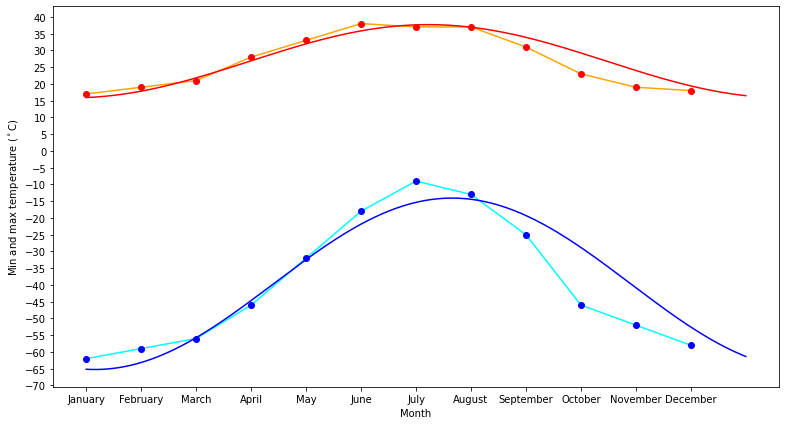

In [5]:
T_df = pd.DataFrame()
T_df['month'] = list(calendar.month_name[1:])
T_df['min'] = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
T_df['max'] = np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
T_df= T_df.set_index('month')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,7))
ax.plot(T_df['max'], color='orange', marker='o', markeredgecolor='red', markerfacecolor='red')
ax.plot(T_df['min'], color='cyan', marker='o', markeredgecolor='blue', markerfacecolor='blue')
ax.set_xlabel('Month')
ax.set_ylabel('Min and max temperature ($^\circ$C)')
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))

def temp_extremes(t, avg, a, t_offset):
    return (avg + a * np.cos((t_offset + t) * 2 * np.pi /(t.max()+1)))
    
par_min, par_cov_min = optimize.curve_fit(temp_extremes, np.arange(12), T_df['min'], [-40, -25, 0])
par_max, par_cov_max = optimize.curve_fit(temp_extremes, np.arange(12), T_df['max'], [25, -10, 0])

print("par fit (average, amplitude, time offset)")
print("min: (guess [-40, -25, 0])\n", par_min, "\n", par_cov_min)
print("max: (guess [25, -10, 0])\n", par_max, "\n", par_cov_max)

days = np.linspace(0, 12, num=365)
ax.plot(days, temp_extremes(days, *par_min), 'b-')
ax.plot(days, temp_extremes(days, *par_max), 'r-')

print("min time offset:", "%.2f" % par_min[2], "±", "%.2f" %  np.sqrt(par_cov_min[2,2]))
print("max time offset:", "%.2f" % par_max[2], "±", "%.2f" %  np.sqrt(par_cov_max[2,2]))

RISPOSTE ALLE DOMANDE:

-> Dal grafico la funzione di fit scelta non pare in buona sovrapposizione coi punti sperimentali, in particolare nella seconda metà dell'anno. Questo perché il raffreddamento appare più rapido del riscaldamento, impedendo alla curva di essere simmetrica rispetto alla verticale tracciata nel massimo

-> No, i due offset temporali non sono compatibili nel proprio range d'errore. A sfasare le due curve potrebbe essere il fatto che solitamente la temperatura minima e massima di un mese non si verificano nello stesso giorno, ma in momenti diversi del mese

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


global minima: ( -0.08984198195041061 , 0.7126563906998463 ) 
( 0.08984198323128446 , -0.7126563912889328 )
function value at global minima:  -1.0316284534898728 , -1.0316284534898732
predicted minimum if (0,0) is the initial guess: ( 0.0 , 0.0 )
it's a wrong result, in fact the function value there is: 0.0


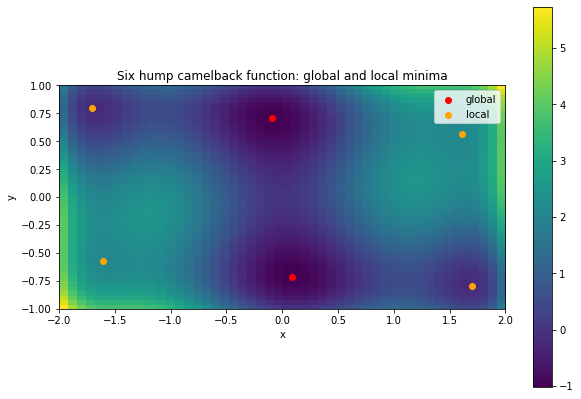

In [7]:

def sixhump(x):
    return ((4 - 2.1*x[0]**2 + x[0]**4 / 3.) * x[0]**2 + x[0] * x[1]
            + (-4 + 4*x[1]**2) * x[1] **2)

x = np.linspace(-2, 2)
y = np.linspace(-1, 1)
xg, yg = np.meshgrid(x, y)

fig, ax1 = plt.subplots(figsize=(10,7)) 

plt.sca(ax1)
plt.imshow(sixhump([xg, yg]), extent=[-2, 2, -1, 1], origin="lower")
plt.colorbar()
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Six hump camelback function: global and local minima')

x_min1 = optimize.minimize(sixhump, x0=[0, 0.5], bounds=[(-0.5, 0.5), (0.5, 1)])
x_min2 = optimize.minimize(sixhump, x0=[0, -0.5], bounds=[(-0.5, 0.5), (-1,-0.5)])
x_min3 = optimize.minimize(sixhump, x0=[-1.75, 0.75], bounds=[(-2, -1.5), (0.5, 1)])
x_min4 = optimize.minimize(sixhump, x0=[1.75, -0.75], bounds=[(1.5, 2), (-1,-0.5)])
x_min5 = optimize.minimize(sixhump, x0=[-1.75, -0.75], bounds=[(-2, -1.5), (-1,-0.5)])
x_min6 = optimize.minimize(sixhump, x0=[1.75, 0.75], bounds=[(1.5, 2), (0.5, 1)])

x_mins = np.array([(x_min1.x[0], x_min1.x[1]), (x_min2.x[0], x_min2.x[1]), (x_min3.x[0], x_min3.x[1]),(x_min4.x[0], x_min4.x[1]),(x_min5.x[0], x_min5.x[1]),(x_min6.x[0], x_min6.x[1])])
print("global minima: (",x_mins[0][0],",", x_mins[0][1],")","\n(",x_mins[1][0],",", x_mins[1][1],")")
print("function value at global minima: ", sixhump(x_mins[0]), ",", sixhump(x_mins[1]))

x_min0 = optimize.minimize(sixhump, x0=[0, 0])
print("predicted minimum if (0,0) is the initial guess: (",x_min0.x[0],",", x_min0.x[1],")")
print("it's a wrong result, in fact the function value there is:", sixhump([x_min0.x[0], x_min0.x[1]]))

for i in range(2):
    plt.scatter(x_mins[i][0], x_mins[i][1], c='red', label='global')
for i in range(2,6):
    plt.scatter(x_mins[i][0], x_mins[i][1], c='orange', label='local')
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.show()

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

peak freq hare: 0.09523809523809523 
peak freq lynx 0.09523809523809523
Il valore delle frequenze di picco è "0.1 1/y", che corrisponde correttamente al 
periodo di circa dieci anni visibile nel grafico superiore


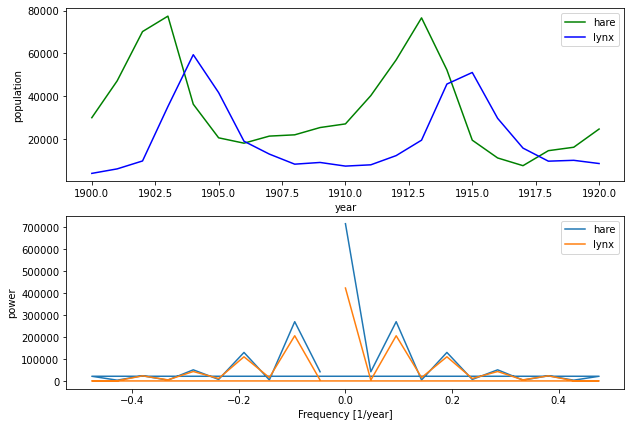

In [10]:
p=np.loadtxt('populations.txt')    
year=np.array(p[:,0])
hare=np.array(p[:,1])
lynx=np.array(p[:,2])
carrot=np.array(p[:,3])
sample_freq = fftpack.fftfreq(year.size)
p_fft = list(map(fftpack.fft, [hare , lynx]))
power = list(map(np.abs, p_fft))
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,7))

ax1.plot(year, hare, 'g', label='hare')
ax1.plot(year, lynx, 'b', label='lynx')
ax1.set_xlabel('year')
ax1.set_ylabel('population')
ax1.legend()

for i in power: 
    ax2.plot(sample_freq,i)
ax2.legend(('hare' , 'lynx'))
ax2.set_xlabel('Frequency [1/year]')
ax2.set_ylabel('power')

pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_hare = freqs[power[0][pos_mask].argmax()]
peak_lynx = freqs[power[1][pos_mask].argmax()]

print("peak freq hare:", peak_hare, "\npeak freq lynx", peak_lynx)
print('Il valore delle frequenze di picco è "0.1 1/y", che corrisponde correttamente al \nperiodo di circa dieci anni visibile nel grafico superiore')

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

Ho difficoltà a visualizzare lo spettro perché dovrei fare 630 grafici separati, 
tanti quante sono le colonne della matrice
Provo quindi con una colormap


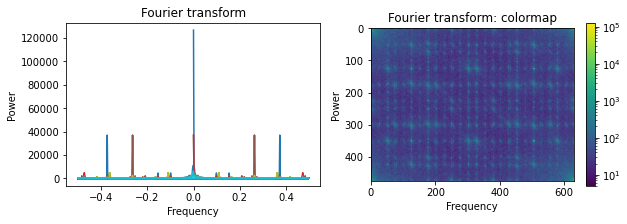

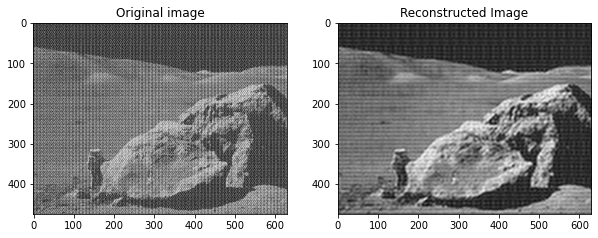

In [14]:
import pylab
m = pylab.imread('moonlanding.png')
#print(m.shape)
sample_freq = fftpack.fftfreq((m.T)[0].size)
m_fft = fftpack.fft2(m)
power = np.abs(m_fft)
fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
fig2, (ax2,ax3) = plt.subplots (nrows=1, ncols=2, figsize=(10,7)) 
ax0.plot(sample_freq,power)
ax0.set_xlabel('Frequency')
ax0.set_ylabel('Power')
ax0.set_title('Fourier transform')
print("Ho difficoltà a visualizzare lo spettro perché dovrei fare 630 grafici separati, \ntanti quante sono le colonne della matrice")
print("Provo quindi con una colormap")

def plot_spectrum(image_fft):
    from matplotlib.colors import LogNorm
    plt.imshow(np.abs(image_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

plt.sca(ax1) 
plot_spectrum(m_fft)
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Power')
ax1.set_title('Fourier transform: colormap')
ax2.imshow(m, plt.cm.gray)
ax2.set_title('Original image')

keep_fraction = 0.102
m_fft2 = m_fft.copy()
r, c = m_fft2.shape
m_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0
m_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0
m_new = fftpack.ifft2(m_fft2).real
ax3.imshow(m_new, plt.cm.gray)
ax3.set_title('Reconstructed Image')
plt.show()